In [127]:
#from statsmodels.tsa.arima_process import ArmaProcess 
#from statsmodels.tsa.stattools import pacf, acf
#from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import PCA_functions as pf
import Extreme_functions as ef


from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

plt.rcParams["figure.figsize"] = (20,10)

from pandas_datareader import wb

In [ ]:
def spiParametersMle(x, dist=st.gamma):
    i = x == 0
    params = dist.fit(x[~i])
    q = len(x[i])/len(x)
    return(params, q)

def spiGeneratorMle(x, dist=st.gamma):
    i = x == 0

    params = dist.fit(x[~i])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    q = len(x[i])/len(x)
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)

def spiGeneratorParamMle(x, params, q, dist=st.gamma):
    i = x == 0
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = dist.cdf(x[~i], loc=loc, scale=scale, *arg)

    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)


In [21]:

level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [75]:
d = Data('../../nc/GPCC_half.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [32]:
spi12 = np.load("../results/SPI12Index.npy")
lat = np.load("../lat.npy")
lon = np.load("../lon.npy")

In [33]:
spi = spi12[1:,:]

In [70]:
coordinates = list(zip(lat_list,lon_list))

In [71]:
dic = rg.search(coordinates)

In [72]:
country = []
for i in range(len(dic)):
    country.append(dic[i].get('cc'))

In [73]:
ET_index = np.where(np.array(country)== "ET")[0]

In [82]:
ET_data = result[:-1,ET_index]

In [106]:
np.save("ET_data.npy",ET_data)

In [107]:
ET_data.shape

(840, 303)

In [237]:
len(ET_index)

303

In [37]:
spi_et = spi[:,ET_index]

In [48]:
result = []
for i in range(spi_et.shape[0]):
    result.append(np.count_nonzero(spi_et[i,:]))

(468, 303)

In [289]:
ET_gamma = np.load("ET_pearson.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


In [290]:
df_count = pd.DataFrame(count,
                  columns=["number"],
                  index=pd.date_range("19770101", periods=len(count), freq='MS'))

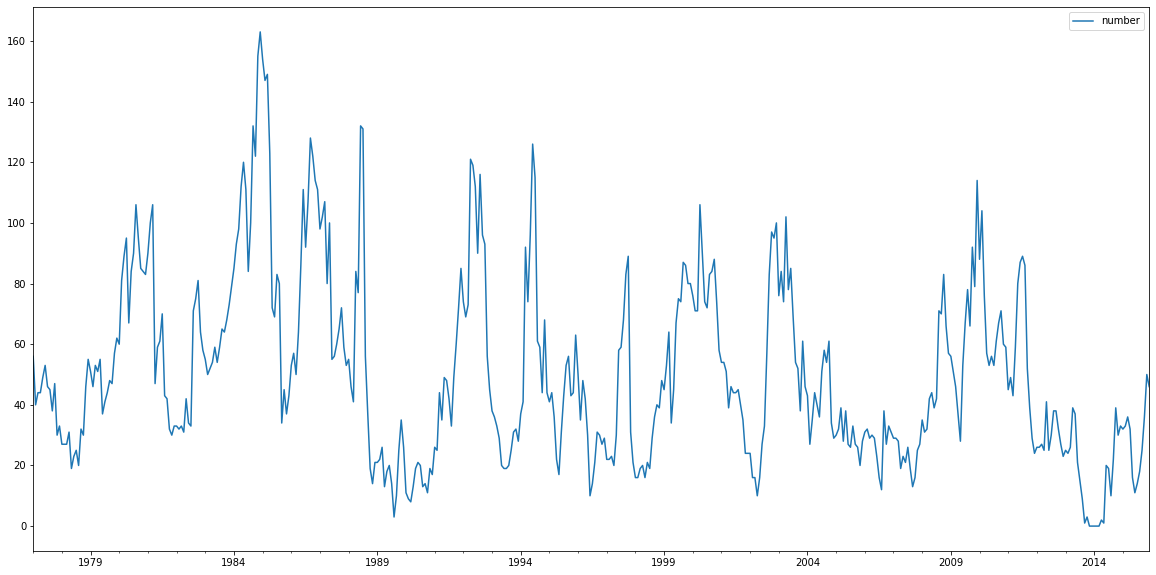

In [291]:
df_count.plot()

In [211]:
ET_gamma = np.load("ET_pearson.npy")
N = ET_gamma.shape[0]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.ma.masked_invalid(ET_gamma[i,:]).mean())

In [274]:
df_extreme = pd.DataFrame({"count":count})
df_extreme = df_extreme.rolling(12).mean()
Idx = np.arange(11,N,12)
df_extreme = df_extreme.iloc[Idx,:]
year = np.arange(1977,2016)
df_extreme["year"] = year

In [275]:
dat = wb.download(indicator='SP.POP.TOTL', country=['ET'], start=1940, end=2019)
year = np.arange(2019,1959, -1)
df = pd.DataFrame({"year":year,"POP":dat["SP.POP.TOTL"].values})



et = pd.read_csv("Data_6.csv")
et  = et.iloc[:,[0,4]]
et = et.dropna()
et["year"] = pd.to_numeric(et["year"])
data = et.merge(df)
data["drought"] = data["Affected"]/data["POP"]
data_et = data.drop(['Affected', 'POP'], axis=1)

In [276]:
df_extreme = df_extreme.merge(data_et, how='left')
df_extreme = df_extreme.set_index("year")
df_extreme = df_extreme.fillna(0)
df_extreme = (df_extreme - df_extreme.mean())/df_extreme.std()

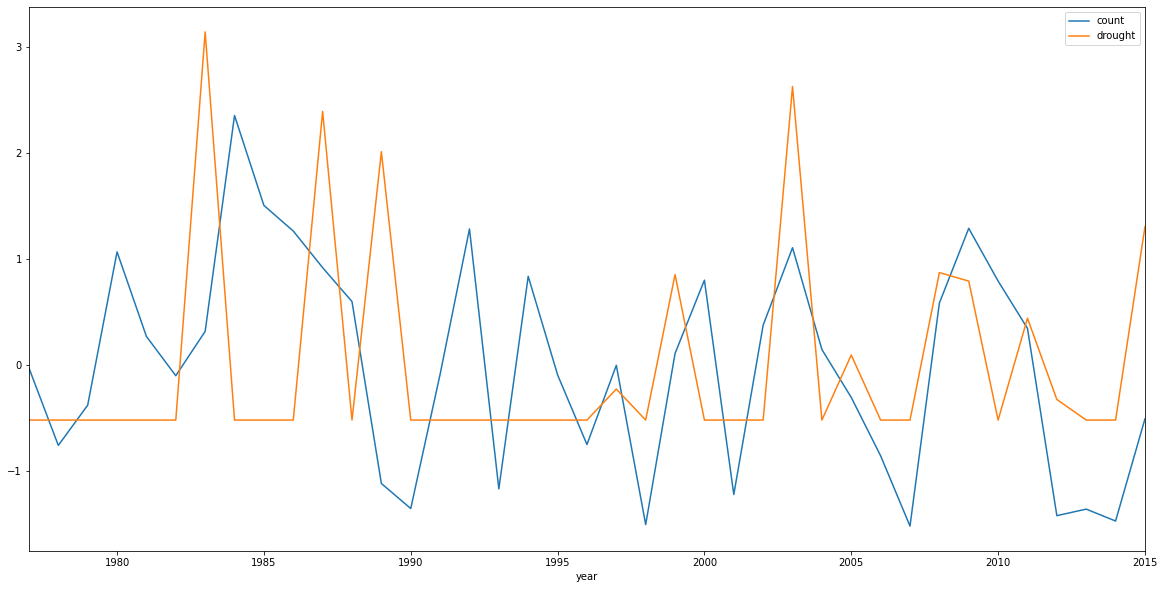

In [277]:
df_extreme.plot()

In [280]:
df_extreme.corr()

,count,drought
count,1.00000,0.16064
drought,0.16064,1.00000


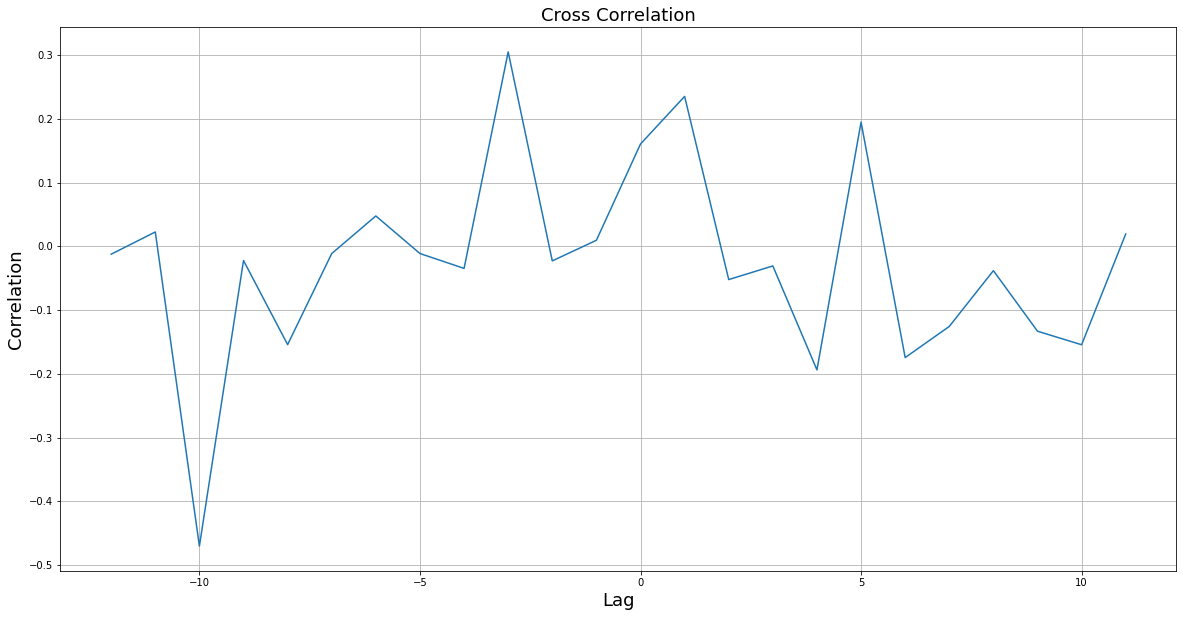

In [281]:
xcov_monthly = [ef.crosscorr(df_extreme["count"],df_extreme["drought"],lag=i) for i in range(-12,12)]
lag = np.arange(-12,12)

fig = plt.figure()
plt.plot(lag, xcov_monthly)
plt.title("Cross Correlation", fontsize = 18)
plt.ylabel("Correlation", fontsize = 18)
plt.xlabel("Lag", fontsize = 18)
plt.grid()
#filename = "../plots/IDD/Corr_{}.png".format(cluster)
#fig.savefig(filename)